In [3]:
!pip install geohash2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15561 sha256=e09f553fd2538efcca8a56456eab58732283812aa95aa2de0e15b1079c2214dd
  Stored in directory: /root/.cache/pip/wheels/5d/61/e3/c3da255d2fc70eb901623d2e0b690f3da6454d5ef713d288ff
Successfully built geohash2


# Utils

In [4]:
import time
import numpy as np 
import pandas as pd
import geohash2 as gh
import tensorflow as tf
import random as python_random
import matplotlib.pyplot as plt

from tensorflow.keras.layers import CategoryEncoding
from tensorflow.keras.preprocessing.sequence import pad_sequences



def bin_geohash(lat, lon, precision=15):
    # Values geohash base 32
    base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    # Binary corresponding values
    binary = [np.asarray(list('{0:05b}'.format(x, 'b')), dtype=int)
          for x in range(0, len(base32))]
    # Dict for conversion
    base32toBin = dict(zip(base32, binary))

    hashed = gh.encode(lat, lon, precision)
    return np.concatenate([base32toBin[x] for x in hashed])


def preproc_marc(df_train, df_test, precision=8):
  df_train, df_test = df_train.copy(), df_test.copy()
  data = [df_train, df_test]
  df = pd.concat([df_train, df_test], ignore_index=True, copy=False) # just for checking

  # Dict for sizes
  vocab_sizes = {i:df[i].unique().size+1 for i in df.columns[:]}
  vocab_sizes['max_len'] = df.groupby('tid').count().max()[0]

  # Dict for encoding
  vocab_encod = {}
  for j in df.columns[-3:]:
    vocab_encod[j] = {sorted(df[j].unique())[i-1]:i for i in range(1,df[j].unique().size+1)} 
  vocab_encod['uid'] = {sorted(df['uid'].unique())[i-1]:i for i in range(1,df['uid'].unique().size+1)}

  # Replace with dict for encoding 
  for d in data:
    for j in df.columns[-3:]:
      d[j] = d[j].replace(to_replace=vocab_encod[j])
  for d in data:
    d['uid'] = d['uid'].replace(to_replace=vocab_encod['uid']) # Replace uid

  # geohash coordinates
  for d in data:
    d['lat_lon'] = [bin_geohash(d.lat.iloc[i], d.lon.iloc[i], precision=precision) for i in range(d.shape[0])]
  vocab_sizes['lat_lon'] = precision * 5 # change to variable precision

  # Re-format datasets
  col = ['uid','tid', 'lat_lon', 'day', 'hour', 'poi']
  df_train = df_train[col]
  df_test = df_test[col]


  # Lists for storing column data
  train = [[] for i in range(len(col))]
  test = [[] for i in range(len(col))]

  # Encoding 
  for i in df_train.tid.unique():
    for j, key in enumerate(col):
      if key == 'uid':
        train[j].append(df_train[df_train.tid==i].uid.unique())
      else:
        train[j].append(df_train[df_train.tid==i].iloc[:,j].to_numpy()) 
        
  for i in df_test.tid.unique():
    for j, key in enumerate(col):
      if key == 'uid':
        test[j].append(df_test[df_test.tid==i].uid.unique())  
      else:
        test[j].append(df_test[df_test.tid==i].iloc[:,j].to_numpy())
    
  # Reformat latlon to match other features
  for t in [train, test]:
    t[2] = np.array([np.array([i.tolist() for i in j]) for j in t[2]], dtype=object)

  train_x, train_y = np.array(train[2:], dtype=object), np.array(train[0], dtype=object)
  test_x, test_y = np.array(test[2:], dtype=object), np.array(test[0], dtype=object)

  # Print Informations 
  print('Trajectories:  ', df.tid.unique().size)
  print('Labels:        ', df.uid.unique().size)
  print('Train size:    ', len(train[0]) / df.tid.unique().size)
  print('Test size:     ', len(test[0]) / df.tid.unique().size)
  print('x_train shape: ', np.array(train_x, dtype=object).shape)
  print('y_train shape: ', np.array(train_y, dtype=object).shape)
  print('x_test shape:  ', np.array(test_x, dtype=object).shape)
  print('y_test shape:  ', np.array(test_y, dtype=object).shape)

  # Pad input sequences 
  train_x = [pad_sequences(f, vocab_sizes['max_len'], dtype='float32', padding='pre') for f in train_x]
  test_x = [pad_sequences(f,vocab_sizes['max_len'], dtype='float32', padding='pre') for f in test_x]
  train_y = np.asarray(train_y).astype('float32')
  test_y = np.asarray(test_y).astype('float32')

  return train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod

# Models

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Add, Average, concatenate, Embedding
from tensorflow.keras.callbacks import EarlyStopping




class MARC():
    def __init__(self, vocab_sizes):
        self.vocab_sizes = vocab_sizes
        # Params
        self.drop_rate = 0.5
        # class_hidden_units = 100
        # class_lrate = 0.001
        # class_batch_size = 64
        # class_epochs = 1000
        # early_stopping_patience = 30
        # baseline_metric = 'acc'
        # baseline_value = 0.5

        self.classifier = self.build_classifier()
        self.classifier.compile(optimizer=Adam(learning_rate=0.001),
                           loss='sparse_categorical_crossentropy', 
                           metrics=['acc', 
                                    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5,name="sparse_top_5_categorical_accuracy"),
                                    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10,name="sparse_top_10_categorical_accuracy")])


    def build_classifier(self):
        # Inputs
        latlon = Input(shape=(self.vocab_sizes['max_len'], self.vocab_sizes['lat_lon']), name='input_latlon')
        day = Input(shape=(self.vocab_sizes['max_len'],), name='input_day')
        hour = Input(shape=(self.vocab_sizes['max_len'],), name='input_hour')
        poi = Input(shape=(self.vocab_sizes['max_len'],), name='input_poi')

        all_inputs = [latlon, day, hour, poi]

        # Embeddings
        latlon_emb = Dense(units=100, activation='relu', kernel_initializer=he_uniform(seed=1), name='emb_latlon')(latlon)
        day_emb = Embedding(vocab_sizes['day'], 100, input_length=vocab_sizes['max_len'], name='emb_day')(day)
        hour_emb = Embedding(vocab_sizes['day'], 100, input_length=vocab_sizes['max_len'], name='emb_hour')(hour)
        poi_emb = Embedding(vocab_sizes['day'], 100, input_length=vocab_sizes['max_len'],  name='emb_poi')(poi)
        # Concatenate embeddings
        all_emb = concatenate(
            [latlon_emb,
            day_emb,
            hour_emb,
            poi_emb])

        # Feature fusion layer
        drop1 = Dropout(self.drop_rate)(all_emb) #add random init
        # LSTM Modeling Layer 
        x = LSTM(units=100, recurrent_regularizer=l1(0.02))(drop1) # add regularizer
        drop2 = Dropout(self.drop_rate)(x) #add random init
        softmax = Dense(self.vocab_sizes['uid'], activation='softmax', kernel_initializer=he_uniform(seed=1))(drop2)
        # Model
        return Model(inputs=all_inputs, outputs=softmax, name='classifier')

    def train(self, x, y, val_x, val_y, save=False, save_path=None):
        history = self.classifier.fit(x=x, 
                                    y=y, 
                                    validation_data=(val_x, val_y),
                                    batch_size=64,
                                    shuffle=True,
                                    epochs=100)
        if save == True:
            # Save
            self.classifier.save_weights(save_path)

        # summarize history for latlon loss
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].plot(history.history['loss'])
        axs[0].plot(history.history['val_loss'])
        axs[0].grid(True)
        axs[1].plot(history.history['acc'])
        axs[1].plot(history.history['val_acc'])
        axs[0].set(title='Loss')
        axs[1].set(title='Acc')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Epoch')
        plt.ylabel('ACC@1')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
        return history
    
    def evaluate(self, x, y, weights):
        self.classifier.load_weights(weights)
        history = self.classifier.evaluate(x, y, batch_size=64, return_dict=True)
        print('[ACC: %.4f] [Top5ACC: %.4f] [Top10ACC: %.4f]'%(history['acc'],
                                                      history['sparse_top_5_categorical_accuracy'],
                                                      history['sparse_top_10_categorical_accuracy']))
        return history

In [6]:
class MARC_noc():
    def __init__(self, vocab_sizes):
        self.vocab_sizes = vocab_sizes
        # Params
        self.drop_rate = 0.5
        # class_hidden_units = 100
        # class_lrate = 0.001
        # class_batch_size = 64
        # class_epochs = 1000
        # early_stopping_patience = 30
        # baseline_metric = 'acc'
        # baseline_value = 0.5

        self.classifier = self.build_classifier()
        self.classifier.compile(optimizer=Adam(learning_rate=0.001),
                           loss='sparse_categorical_crossentropy', 
                           metrics=['acc', 
                                    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5,name="sparse_top_5_categorical_accuracy"),
                                    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10,name="sparse_top_10_categorical_accuracy")])


    def build_classifier(self):
        # Inputs
        # latlon = Input(shape=(self.vocab_sizes['max_len'], self.vocab_sizes['lat_lon']), name='input_latlon')
        day = Input(shape=(self.vocab_sizes['max_len'],), name='input_day')
        hour = Input(shape=(self.vocab_sizes['max_len'],), name='input_hour')
        poi = Input(shape=(self.vocab_sizes['max_len'],), name='input_poi')

        all_inputs = [day, hour, poi]

        # Embeddings
        # latlon_emb = Dense(units=100, activation='relu', kernel_initializer=he_uniform(seed=1), name='emb_latlon')(latlon)
        day_emb = Embedding(vocab_sizes['day'], 100, input_length=vocab_sizes['max_len'], name='emb_day')(day)
        hour_emb = Embedding(vocab_sizes['day'], 100, input_length=vocab_sizes['max_len'], name='emb_hour')(hour)
        poi_emb = Embedding(vocab_sizes['day'], 100, input_length=vocab_sizes['max_len'],  name='emb_poi')(poi)
        # Concatenate embeddings
        all_emb = concatenate(
            [day_emb,
            hour_emb,
            poi_emb])

        # Feature fusion layer
        drop1 = Dropout(self.drop_rate)(all_emb) #add random init
        # LSTM Modeling Layer 
        x = LSTM(units=100, recurrent_regularizer=l1(0.02))(drop1) # add regularizer
        drop2 = Dropout(self.drop_rate)(x) #add random init
        softmax = Dense(self.vocab_sizes['uid'], activation='softmax', kernel_initializer=he_uniform(seed=1))(drop2)
        # Model
        return Model(inputs=all_inputs, outputs=softmax, name='classifier')

    def train(self, x, y, val_x, val_y, save=False, save_path=None):
        history = self.classifier.fit(x=x, 
                                    y=y, 
                                    validation_data=(val_x, val_y),
                                    batch_size=64,
                                    shuffle=True,
                                    epochs=100)
        if save == True:
            # Save
            self.classifier.save_weights(save_path)

        # summarize history for latlon loss
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].plot(history.history['loss'])
        axs[0].plot(history.history['val_loss'])
        axs[0].grid(True)
        axs[1].plot(history.history['acc'])
        axs[1].plot(history.history['val_acc'])
        axs[0].set(title='Loss')
        axs[1].set(title='Acc')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Epoch')
        plt.ylabel('ACC@1')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
        return history
    
    def evaluate(self, x, y, weights):
        self.classifier.load_weights(weights)
        history = self.classifier.evaluate(x, y, batch_size=64, return_dict=True)
        print('[ACC: %.4f] [Top5ACC: %.4f] [Top10ACC: %.4f]'%(history['acc'],
                                                      history['sparse_top_5_categorical_accuracy'],
                                                      history['sparse_top_10_categorical_accuracy']))
        return history

# Breadcrumbs

### Default

Trajectories:   1108
Labels:         80
Train size:     0.7111913357400722
Test size:      0.2888086642599278
x_train shape:  (4, 788)
y_train shape:  (788, 1)
x_test shape:   (4, 320)
y_test shape:   (320, 1)
Epoch 1/100
13/13 [==============================] - 8s 72ms/step - loss: 32.1518 - acc: 0.0152 - sparse_top_5_categorical_accuracy: 0.0761 - sparse_top_10_categorical_accuracy: 0.1472 - val_loss: 26.9573 - val_acc: 0.1406 - val_sparse_top_5_categorical_accuracy: 0.3406 - val_sparse_top_10_categorical_accuracy: 0.4437
Epoch 2/100
13/13 [==============================] - 0s 26ms/step - loss: 23.7054 - acc: 0.0749 - sparse_top_5_categorical_accuracy: 0.2297 - sparse_top_10_categorical_accuracy: 0.3490 - val_loss: 19.6339 - val_acc: 0.4156 - val_sparse_top_5_categorical_accuracy: 0.6281 - val_sparse_top_10_categorical_accuracy: 0.7250
Epoch 3/100
13/13 [==============================] - 0s 22ms/step - loss: 17.1631 - acc: 0.1904 - sparse_top_5_categorical_accuracy: 0.4416 - sparse_t

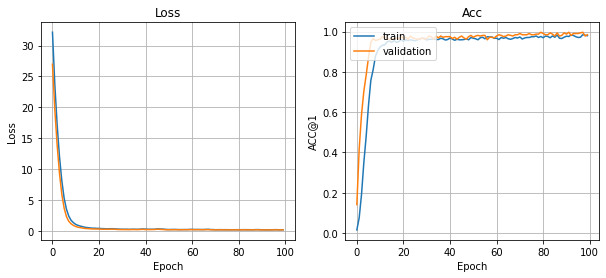

Exec time: 40.568567991256714 s
Exec proc time: 40.88899406600001 s
5/5 [==============================] - 0s 9ms/step - loss: 0.1351 - acc: 0.9844 - sparse_top_5_categorical_accuracy: 1.0000 - sparse_top_10_categorical_accuracy: 1.0000
[ACC: 0.9844] [Top5ACC: 1.0000] [Top10ACC: 1.0000]
Exec time: 0.14315152168273926 s
Exec proc time: 0.13361553000000015 s


In [7]:
train_file = 'data/breadcrumbs/train.csv'
test_file = 'data/breadcrumbs/test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)



marc = MARC(vocab_sizes)

start, start_proc = time.time(), time.process_time()
marc.train(train_x, train_y, test_x, test_y, 
           save=True, save_path="training_params/marc/breadcrumbs_TUL.h5")

end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

start, start_proc = time.time(), time.process_time()
h = marc.evaluate(test_x, test_y, 'training_params/marc/breadcrumbs_TUL.h5')
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

Test with synthetic data

In [8]:
train_file = 'data/breadcrumbs/train_synth.csv'
test_file = 'data/breadcrumbs/test_synth.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

marc = MARC(vocab_sizes)

h = marc.evaluate(test_x, test_y, 'training_params/marc/breadcrumbs_TUL.h5')

Trajectories:   1108
Labels:         80
Train size:     0.7111913357400722
Test size:      0.2888086642599278
x_train shape:  (4, 788)
y_train shape:  (788, 1)
x_test shape:   (4, 320)
y_test shape:   (320, 1)
5/5 [==============================] - 1s 13ms/step - loss: 7.6859 - acc: 0.0625 - sparse_top_5_categorical_accuracy: 0.1219 - sparse_top_10_categorical_accuracy: 0.1937
[ACC: 0.0625] [Top5ACC: 0.1219] [Top10ACC: 0.1937]


### No Coords

Trajectories:   1108
Labels:         80
Train size:     0.7111913357400722
Test size:      0.2888086642599278
x_train shape:  (4, 788)
y_train shape:  (788, 1)
x_test shape:   (4, 320)
y_test shape:   (320, 1)
Epoch 1/100
13/13 [==============================] - 3s 64ms/step - loss: 32.1053 - acc: 0.0140 - sparse_top_5_categorical_accuracy: 0.0546 - sparse_top_10_categorical_accuracy: 0.1053 - val_loss: 27.1399 - val_acc: 0.0156 - val_sparse_top_5_categorical_accuracy: 0.0719 - val_sparse_top_10_categorical_accuracy: 0.1219
Epoch 2/100
13/13 [==============================] - 0s 21ms/step - loss: 23.9046 - acc: 0.0178 - sparse_top_5_categorical_accuracy: 0.0736 - sparse_top_10_categorical_accuracy: 0.1307 - val_loss: 20.0755 - val_acc: 0.0125 - val_sparse_top_5_categorical_accuracy: 0.0719 - val_sparse_top_10_categorical_accuracy: 0.1375
Epoch 3/100
13/13 [==============================] - 0s 21ms/step - loss: 17.6218 - acc: 0.0241 - sparse_top_5_categorical_accuracy: 0.0901 - sparse_t

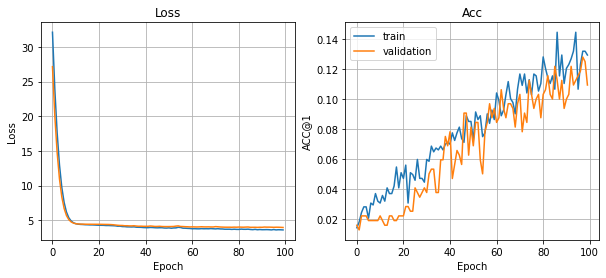

Exec time: 30.534693956375122 s
Exec proc time: 33.658947055 s
5/5 [==============================] - 0s 8ms/step - loss: 3.9618 - acc: 0.1094 - sparse_top_5_categorical_accuracy: 0.2750 - sparse_top_10_categorical_accuracy: 0.4094
[ACC: 0.1094] [Top5ACC: 0.2750] [Top10ACC: 0.4094]
Exec time: 0.11354660987854004 s
Exec proc time: 0.10983899900000438 s


In [9]:
train_file = 'data/breadcrumbs/train.csv'
test_file = 'data/breadcrumbs/test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

marc = MARC_noc(vocab_sizes)

start, start_proc = time.time(), time.process_time()
marc.train(train_x[1:], train_y, test_x[1:], test_y, 
           save=True, save_path="training_params/marc/breadcrumbs_TUL_noc.h5")
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')


start, start_proc = time.time(), time.process_time()
h = marc.evaluate(test_x[1:], test_y, 'training_params/marc/breadcrumbs_TUL_noc.h5')
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

Test with synthetic data 

In [10]:
train_file = 'data/breadcrumbs/train_synth.csv'
test_file = 'data/breadcrumbs/test_synth.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

marc = MARC_noc(vocab_sizes)

h = marc.evaluate(test_x[1:], test_y, 'training_params/marc/breadcrumbs_TUL_noc.h5')

Trajectories:   1108
Labels:         80
Train size:     0.7111913357400722
Test size:      0.2888086642599278
x_train shape:  (4, 788)
y_train shape:  (788, 1)
x_test shape:   (4, 320)
y_test shape:   (320, 1)
5/5 [==============================] - 1s 11ms/step - loss: 4.1210 - acc: 0.0812 - sparse_top_5_categorical_accuracy: 0.2031 - sparse_top_10_categorical_accuracy: 0.3313
[ACC: 0.0812] [Top5ACC: 0.2031] [Top10ACC: 0.3313]


# Foursquare (categorical POIs)

### Default

Trajectories:   3079
Labels:         193
Train size:     0.6664501461513478
Test size:      0.33354985384865216
x_train shape:  (4, 2052)
y_train shape:  (2052, 1)
x_test shape:   (4, 1027)
y_test shape:   (1027, 1)
Epoch 1/100
33/33 [==============================] - 3s 39ms/step - loss: 27.0488 - acc: 0.0107 - sparse_top_5_categorical_accuracy: 0.0409 - sparse_top_10_categorical_accuracy: 0.0707 - val_loss: 17.8281 - val_acc: 0.0117 - val_sparse_top_5_categorical_accuracy: 0.1207 - val_sparse_top_10_categorical_accuracy: 0.1870
Epoch 2/100
33/33 [==============================] - 1s 20ms/step - loss: 13.0069 - acc: 0.0302 - sparse_top_5_categorical_accuracy: 0.0814 - sparse_top_10_categorical_accuracy: 0.1355 - val_loss: 8.9066 - val_acc: 0.0506 - val_sparse_top_5_categorical_accuracy: 0.1782 - val_sparse_top_10_categorical_accuracy: 0.2707
Epoch 3/100
33/33 [==============================] - 1s 20ms/step - loss: 7.1862 - acc: 0.0565 - sparse_top_5_categorical_accuracy: 0.1389 - spar

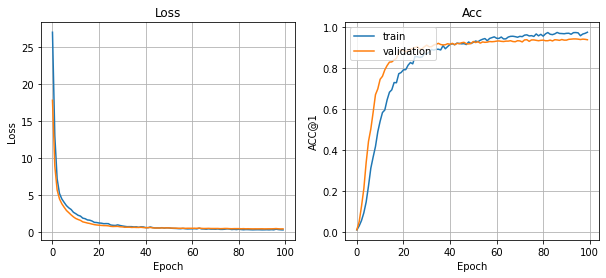

Exec time: 70.69379162788391 s
Exec proc time: 82.94499936700001 s
17/17 [==============================] - 0s 9ms/step - loss: 0.4067 - acc: 0.9377 - sparse_top_5_categorical_accuracy: 0.9796 - sparse_top_10_categorical_accuracy: 0.9854
[ACC: 0.9377] [Top5ACC: 0.9796] [Top10ACC: 0.9854]
Exec time: 0.39377570152282715 s
Exec proc time: 0.2669722310000111 s


In [11]:
train_file = 'data/foursquare/train_cat.csv'
test_file = 'data/foursquare/test_cat.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

marc = MARC(vocab_sizes)
start, start_proc = time.time(), time.process_time()
marc.train(train_x, train_y, test_x, test_y, 
           save=True, save_path="training_params/marc/foursquare_cat_TUL.h5")
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

start, start_proc = time.time(), time.process_time()
h = marc.evaluate(test_x, test_y, 'training_params/marc/foursquare_cat_TUL.h5')
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

Test with synthetic data

In [12]:
train_file = 'data/foursquare/train_cat_synth.csv'
test_file = 'data/foursquare/test_cat_synth.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

marc = MARC(vocab_sizes)
# marc.train(train_x, train_y, test_x, test_y, 
#            save=True, save_path="training_params/marc/foursquare_cat_TUL.h5")
h = marc.evaluate(test_x, test_y, 'training_params/marc/foursquare_cat_TUL.h5')

Trajectories:   3079
Labels:         193
Train size:     0.6664501461513478
Test size:      0.33354985384865216
x_train shape:  (4, 2052)
y_train shape:  (2052, 1)
x_test shape:   (4, 1027)
y_test shape:   (1027, 1)
17/17 [==============================] - 1s 12ms/step - loss: 4.0646 - acc: 0.2093 - sparse_top_5_categorical_accuracy: 0.4839 - sparse_top_10_categorical_accuracy: 0.6183
[ACC: 0.2093] [Top5ACC: 0.4839] [Top10ACC: 0.6183]


### No Coords

Trajectories:   3079
Labels:         193
Train size:     0.6664501461513478
Test size:      0.33354985384865216
x_train shape:  (4, 2052)
y_train shape:  (2052, 1)
x_test shape:   (4, 1027)
y_test shape:   (1027, 1)
Epoch 1/100
33/33 [==============================] - 3s 36ms/step - loss: 26.9944 - acc: 0.0088 - sparse_top_5_categorical_accuracy: 0.0463 - sparse_top_10_categorical_accuracy: 0.0750 - val_loss: 17.8820 - val_acc: 0.0380 - val_sparse_top_5_categorical_accuracy: 0.1139 - val_sparse_top_10_categorical_accuracy: 0.1840
Epoch 2/100
33/33 [==============================] - 1s 17ms/step - loss: 13.0417 - acc: 0.0210 - sparse_top_5_categorical_accuracy: 0.0785 - sparse_top_10_categorical_accuracy: 0.1447 - val_loss: 9.0773 - val_acc: 0.0506 - val_sparse_top_5_categorical_accuracy: 0.1168 - val_sparse_top_10_categorical_accuracy: 0.1772
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 7.3609 - acc: 0.0297 - sparse_top_5_categorical_accuracy: 0.1019 - spar

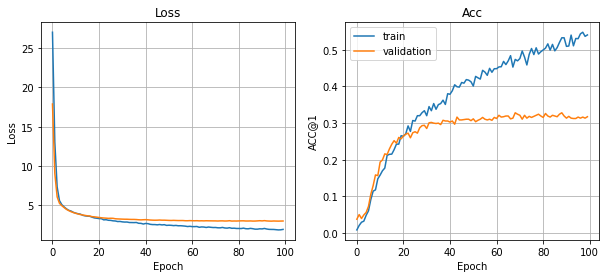

Exec time: 84.79771876335144 s
Exec proc time: 71.485582384 s
17/17 [==============================] - 0s 9ms/step - loss: 3.0281 - acc: 0.3174 - sparse_top_5_categorical_accuracy: 0.6076 - sparse_top_10_categorical_accuracy: 0.7128
[ACC: 0.3174] [Top5ACC: 0.6076] [Top10ACC: 0.7128]
Exec time: 0.5267181396484375 s
Exec proc time: 0.4984326759999931 s


In [13]:
train_file = 'data/foursquare/train_cat.csv'
test_file = 'data/foursquare/test_cat.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

marc = MARC_noc(vocab_sizes)
start, start_proc = time.time(), time.process_time()
marc.train(train_x[1:], train_y, test_x[1:], test_y, 
           save=True, save_path="training_params/marc/foursquare_cat_TUL_noc.h5")
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

start, start_proc = time.time(), time.process_time()
h = marc.evaluate(test_x[1:], test_y, 'training_params/marc/foursquare_cat_TUL_noc.h5')
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

Test with synthhetic data

In [14]:
train_file = 'data/foursquare/train_cat_synth.csv'
test_file = 'data/foursquare/test_cat_synth.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod = preproc_marc(df_train, df_test)

np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

marc = MARC_noc(vocab_sizes)
# marc.train(train_x[1:], train_y, test_x[1:], test_y, 
#            save=True, save_path="training_params/marc/foursquare_cat_TUL_noc.h5")
h = marc.evaluate(test_x[1:], test_y, 'training_params/marc/foursquare_cat_TUL_noc.h5')

Trajectories:   3079
Labels:         193
Train size:     0.6664501461513478
Test size:      0.33354985384865216
x_train shape:  (4, 2052)
y_train shape:  (2052, 1)
x_test shape:   (4, 1027)
y_test shape:   (1027, 1)
17/17 [==============================] - 1s 9ms/step - loss: 3.0271 - acc: 0.3184 - sparse_top_5_categorical_accuracy: 0.6086 - sparse_top_10_categorical_accuracy: 0.7137
[ACC: 0.3184] [Top5ACC: 0.6086] [Top10ACC: 0.7137]


# Previous results

In [ ]:
# NO l1 regularize on ltsm nor he_uniform on dense
[ACC: 0.9625] [Top5ACC: 1.0000] [Top10ACC: 1.0000] # Breadcrumbs
[ACC: 0.8724] [Top5ACC: 0.9552] [Top10ACC: 0.9757] # Foursquare

In [ ]:
# Regularizer and he_uniform (with mask)
[ACC: 0.9299] [Top5ACC: 0.9815] [Top10ACC: 0.9873] # Foursquare
[ACC: 0.9318] [Top5ACC: 0.9786] [Top10ACC: 0.9873] # Foursquare no mask (freaking faster and less epochs)